In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import os

import plotly.express as px


## Data processing

In [16]:

RELATIVEPATH = ".\\Assets\\Data\\"

loadedData = []

#print all the folders in the directory

for root, dirs, files in os.walk(RELATIVEPATH):
    for name in dirs:

        try:
            int(name)
        except:
            continue

        loadedData.append(os.path.join(root, name))


In [17]:
def getCrash(df):
    crash = df.groupby("droneId").count()[["Time"]].reset_index()
    maxCrash = crash["Time"].max()

    droneCrash = crash[crash["Time"] != maxCrash][["droneId", "Time"]].values

    dfCrash = pd.DataFrame(columns=["droneId", "Time"])

    for drone in droneCrash:
        timeCrash = df[df["droneId"] == drone[0]]["Time"].max()
        dfCrash.loc[len(dfCrash)] = [drone[0], timeCrash]
        
    return dfCrash

def analyseFile(folderPath, file):
    separators = file.split('_')
    run = 0
    obstacle = ''
    view = ''
    haptics = ''
    order = ''

    if len(separators) == 4:
        run = 1
    elif len(separators) == 5:
        run = 2
    else:
        raise Exception("This is not a valid file")

    if "Obs" in separators[0]:
        obstacle = "Obstacle"
    elif "Collectibles" in separators[0]:
        obstacle = "Collectibles"
    else:
        raise Exception("This is not a valid file")
    
    if "TDV" in separators[0]:
        view = "TDV"
    elif "FPV" in separators[0]:
        view = "FPV"
    else:
        raise Exception("This is not a valid file")
    
    if "NH" in separators[-3]:
        haptics = "NH"
    elif "H" in separators[-3]:
        haptics = "H"
    else:
        raise Exception("This is not a valid file")
    
    if "NO" in separators[-2]:
        order = "NO"
    elif "O" in separators[-2]:
        order = "O"
    else:
        raise Exception("This is not a valid file")
    
    date = separators[-1][:-5]

    file = os.path.join(folderPath, file)

    PID = folderPath.split('\\')[-1]

   # data = pd.read_json(file)
    
    #make a dataframe of the data
    di = {"PID":PID, "Run" : run, "Obstacle" : obstacle, "View" : view, "Haptics" : haptics, "Order" : order, "Date" : date, "File" : file}

    return di

def makeFromFolder(folderPath):
    files = os.listdir(folderPath)
    files = [f for f in files if f.endswith('.json')]
    foreachFile = [analyseFile(folderPath, f) for f in files]
    return foreachFile

def makeFromFolders(folders):
    foreachFolder = [makeFromFolder(f) for f in folders]
    print(foreachFolder)
    return foreachFolder

def analyseSwarmState(data, time): ### ake data["swarmState"]
    rows = []

    for drone_entry in data:
        drone_entry.keys()
        drone_id = int(drone_entry["droneId"])
        drone_state = drone_entry["droneState"]

#['position', 'velocity', 'FobstacleAvoidance', 'FolfatiSaber', 'Falignment', 'network', 'layer', 'crashedPred']
        positions = drone_state.get("position", [])
        velocities = drone_state.get("velocity", [])
        obstacles = drone_state.get("FobstacleAvoidance", [])
        allignement = drone_state.get("Falignment", [])
        olfati = drone_state.get("FolfatiSaber", [])
        # embodied_list = drone_state.get("embodied", [])
        # selected_list = drone_state.get("selected", [])
        network_list = drone_state.get("network", [])
        layer_list = drone_state.get("layer", [])
        crashedPred_list = drone_state.get("crashedPred", [])

        # Determine how many time steps exist for this drone
        number_of_time_steps = max(
            len(positions),
            len(velocities),
            len(network_list),
            len(obstacles),
            len(olfati),
            len(allignement)
        )

        for i in range(number_of_time_steps):
            # Fetch the position dictionary if it exists, otherwise {}
            if i < len(positions) and isinstance(positions[i], dict):
                pos = positions[i]
                posX = pos.get("x", None)
                posY = pos.get("y", None)
                posZ = pos.get("z", None)
            else:
                posX, posY, posZ = None, None, None

            # Fetch the velocity dictionary if it exists, otherwise {}
            if i < len(velocities) and isinstance(velocities[i], dict):
                vel = velocities[i]
                velX = vel.get("x", None)
                velY = vel.get("y", None)
                velZ = vel.get("z", None)
            else:
                velX, velY, velZ = None, None, None

            if i < len(obstacles) and isinstance(obstacles[i], dict):
                obs = obstacles[i]
                obsX = obs.get("x", None)
                obsY = obs.get("y", None)
                obsZ = obs.get("z", None)

            if i < len(olfati) and isinstance(olfati[i], dict):
                olf = olfati[i]
                olfX = olf.get("x", None)
                olfY = olf.get("y", None)
                olfZ = olf.get("z", None)

            if i < len(allignement) and isinstance(allignement[i], dict):
                all = allignement[i]
                allX = all.get("x", None)
                allY = all.get("y", None)
                allZ = all.get("z", None)

            net = network_list[i] if i < len(network_list) else None
            layer = layer_list[i] if i < len(layer_list) else None
            crashedPred = crashedPred_list[i] if i < len(crashedPred_list) else None

            row_data = {
                "droneId": drone_id,
                "Time": time[i],
                "posX": posX,
                "posY": posY,
                "posZ": posZ,
                "velX": velX,
                "velY": velY,
                "velZ": velZ,
                "obsX": obsX,
                "obsY": obsY,
                "obsZ": obsZ,
                "olfX": olfX,
                "olfY": olfY,
                "olfZ": olfZ,
                "allX": allX,
                "allY": allY,
                "allZ": allZ,
                "network": net,
                "layer": layer,
                "crashedPred": crashedPred
                
            }

            rows.append(row_data)



    df = pd.DataFrame(rows)

    return df

def getInfo(index):

    with open(dfFolders.iloc[index]["File"], "r") as f: 
        data = json.load(f)

    rows = []

    # Read top-level constants (if you want them in every row)
    max_speed = data.get("maxSpeed", None)
    max_force = data.get("maxForce", None)
    neighbor_radius = data.get("neighborRadius", None)
    maxSpeed = data.get("maxSpeed", None)
    maxForce = data.get("maxForce", None)
    alpha = data.get("alpha", None)
    beta = data.get("beta", None)
    delta = data.get("delta", None)
    cvm = data.get("cvm", None)
    avoidance_radius = data.get("avoidanceRadius", None)
    desiredSeparationToObs = data.get("desiredSeparationToObs", None)
    avoidance_force = data.get("avoidanceForce", None)
    drone_radius = data.get("droneRadius", None)
    damping_factor = data.get("dampingFactor", None)

    constants = {"max_speed": max_speed, "max_force": max_force, "neighbor_radius": neighbor_radius, "maxSpeed": maxSpeed, "maxForce": maxForce, "alpha": alpha, "beta": beta, "delta": delta, "cvm": cvm, "avoidance_radius": avoidance_radius, "desiredSeparationToObs": desiredSeparationToObs, "avoidance_force": avoidance_force, "drone_radius": drone_radius, "damping_factor": damping_factor}

    cameraForward = data.get("cameraForward", None)
    subNetworkNumber = data.get("subNetworkNumber", None)
    idLeader = data.get("idLeader", None)
    isolation = data.get("isolation", None)
    swarmConnectivness = data.get("swarmConnectivness", None)
    time = data.get("time", None)
    alignment = data.get("alignment", None)
    desiredSeparation = data.get("desiredSeparation", None)
    #make a df of the data

    dic = {"Time": time, "cameraForward": cameraForward, "subNetworkNumber": subNetworkNumber, "idLeader": idLeader, "isolation": isolation, "swarmConnectivness": swarmConnectivness, "alignment": alignment, "desiredSeparation": desiredSeparation}
    dfStudy = pd.DataFrame(dic) 



    swarmState = data.get("swarmState", None)
    dfSwarmState = cleanData(analyseSwarmState(swarmState, time))

    stars = data.get("stars", None)
    dfStars = pd.DataFrame(stars)

    dfCrashed = getCrash(dfSwarmState)
    #
    return cleanData(dfStudy), dfStars, constants, dfSwarmState, dfCrashed

def cleanData(df):
    #remove the rows where time  <= 0
    df = df[df["Time"] > 0]
    #remove the rows where time is not a number

    return df

dfFolders = makeFromFolders(loadedData)
dfFolders = pd.DataFrame([item for sublist in dfFolders for item in sublist])

[[{'PID': '1436', 'Run': 2, 'Obstacle': 'Collectibles', 'View': 'FPV', 'Haptics': 'NH', 'Order': 'O', 'Date': '', 'File': '.\\Assets\\Data\\1436\\FPVCollectibles_1_NH_O_.json'}, {'PID': '1436', 'Run': 1, 'Obstacle': 'Collectibles', 'View': 'FPV', 'Haptics': 'NH', 'Order': 'O', 'Date': '', 'File': '.\\Assets\\Data\\1436\\FPVCollectibles_NH_O_.json'}, {'PID': '1436', 'Run': 2, 'Obstacle': 'Obstacle', 'View': 'FPV', 'Haptics': 'NH', 'Order': 'O', 'Date': '', 'File': '.\\Assets\\Data\\1436\\FPVObs_1_NH_O_.json'}, {'PID': '1436', 'Run': 1, 'Obstacle': 'Obstacle', 'View': 'FPV', 'Haptics': 'NH', 'Order': 'O', 'Date': '', 'File': '.\\Assets\\Data\\1436\\FPVObs_NH_O_.json'}, {'PID': '1436', 'Run': 2, 'Obstacle': 'Collectibles', 'View': 'TDV', 'Haptics': 'NH', 'Order': 'O', 'Date': '', 'File': '.\\Assets\\Data\\1436\\TDVCollectibles_1_NH_O_.json'}, {'PID': '1436', 'Run': 1, 'Obstacle': 'Collectibles', 'View': 'TDV', 'Haptics': 'NH', 'Order': 'O', 'Date': '', 'File': '.\\Assets\\Data\\1436\\TDVC

In [40]:

for index in range(0,len(dfFolders)):
    print(index, sep=' ', end=' ', flush=True)
    dfFolders.at[index, "Crash"] = pd.DataFrame(columns=["droneId", "Time"])
    dfFolders.at[index, "Study"] = pd.DataFrame(columns=["Time", "cameraForward", "subNetworkNumber", "idLeader", "isolation", "swarmConnectivness", "alignment", "desiredSeparation"])
    dfFolders.at[index, "Stars"] = pd.DataFrame(columns=["droneId", "starId", "starType", "starPosition", "starRadius", "starColor", "starIntensity", "starDirection", "starAngle", "starDistance", "starSpeed", "starTime"])
    dfFolders.at[index, "SwarmState"] = pd.DataFrame(columns=["droneId", "Time", "posX", "posY", "posZ", "velX", "velY", "velZ", "obsX", "obsY", "obsZ", "olfX", "olfY", "olfZ", "allX", "allY", "allZ", "network", "layer", "crashedPred"])
    
    dfStudy, dfStars, constants, dfSwarmState, dfCrash = getInfo(index)

    #Sve it in the dfFolders
    dfFolders.at[index, "Crash"] = dfCrash
    dfFolders.at[index, "Study"] = dfStudy
    dfFolders.at[index, "Stars"] = dfStars
    dfFolders.at[index, "SwarmState"] = dfSwarmState


    dfFolders.at[index, "Constants"] = pd.DataFrame(constants, index=[0])

    dfFolders.at[index, "FinalTime"] = dfStudy["Time"].max()

    dfFolders.at[index, "NumberOfCrash"] = len(dfCrash)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

In [41]:
#drop to pickle

dfFolders.to_pickle("dfFoldersFinal.pkl")

## Data anylsis

In [3]:
#read from pickle

dfFolders = pd.read_pickle("dfFoldersFinal.pkl")

    

In [4]:
dfFolders.sample(2)

,PID,Run,Obstacle,View,Haptics,Order,Date,File,Crash,Study,Stars,SwarmState,Constants,FinalTime,NumberOfCrash
17,3201,1,Collectibles,FPV,H,NO,2025-03-03-14-56-19,.\Assets\Data\3201\FPVCollectibles_H_NO_2025-0...,"Empty DataFrame Columns: [droneId, Time] Index...",Time ...,starName timeCollected droneId \ 0 ...,droneId Time posX po...,max_speed max_force neighbor_radius maxSp...,165.405060,0.0
10,179,2,Obstacle,FPV,NH,O,,.\Assets\Data\179\FPVObs_1_NH_O_.json,droneId Time 0 0.0 32.692028 1 ...,Time ...,Empty DataFrame Columns: [] Index: [],droneId Time posX posY...,max_speed max_force neighbor_radius maxSp...,80.121849,2.0


In [5]:
def violinGraphSituation(df, metric):
    grouped = df.groupby(["View", "Obstacle"])
    
    all_data = []
    positions = []
    x_labels = []
    colors = []
    pos_counter = 1
    scenario_separators = []

    prev_view_obstacle = None
    for (view, obstacle), subset in grouped:
        h_times = subset[subset["Haptics"] == "H"][metric].values
        nh_times = subset[subset["Haptics"] == "NH"][metric].values
        
        h_count = len(h_times)
        nh_count = len(nh_times)
        
        all_data.append(h_times)
        positions.append(pos_counter)
        x_labels.append(f"{view}-{obstacle}-H\n(n={h_count})")
        colors.append("red")
        pos_counter += 1

        all_data.append(nh_times)
        positions.append(pos_counter)
        x_labels.append(f"{view}-{obstacle}-NH\n(n={nh_count})")
        colors.append("blue")
        pos_counter += 1

        if prev_view_obstacle is not None and prev_view_obstacle != (view, obstacle):
            scenario_separators.append(pos_counter - 2)  # Adjust separator position
        prev_view_obstacle = (view, obstacle)
    
    plt.figure(figsize=(12, 6))
    violin_parts = plt.violinplot(dataset=all_data, positions=positions, showmeans=True)
    
    for i, pc in enumerate(violin_parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

    for partname in ['cbars', 'cmins', 'cmaxes', 'cmeans']:
        vp = violin_parts[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)
    
    for sep in scenario_separators:
        plt.axvline(x=sep-0.5, color='black', linestyle='--', linewidth=1)
    
    plt.xticks(positions, x_labels, rotation=45, ha='right')
    plt.xlabel("View - Obstacle - Haptics")
    plt.ylabel(metric)
    plt.title(f"Violin Plot of {metric} by View, Obstacle, and Haptics (H=Red, NH=Blue)")
    plt.tight_layout()
    plt.show()

def boxPlotSituation(df, metric):
    grouped = df.groupby(["View", "Obstacle"])
    
    all_data = []
    positions = []
    x_labels = []
    colors = []
    pos_counter = 1
    scenario_separators = []
    
    prev_view_obstacle = None
    for (view, obstacle), subset in grouped:
        h_times = subset[subset["Haptics"] == "H"][metric].values
        nh_times = subset[subset["Haptics"] == "NH"][metric].values
        
        h_count = len(h_times)
        nh_count = len(nh_times)
        
        all_data.append(h_times)
        positions.append(pos_counter)
        x_labels.append(f"{view}-{obstacle}-H\n(n={h_count})")
        colors.append("red")
        pos_counter += 1
        
        all_data.append(nh_times)
        positions.append(pos_counter)
        x_labels.append(f"{view}-{obstacle}-NH\n(n={nh_count})")
        colors.append("blue")
        pos_counter += 1
        
        if prev_view_obstacle is not None and prev_view_obstacle != (view, obstacle):
            scenario_separators.append(pos_counter - 2)  # Adjust separator position
        prev_view_obstacle = (view, obstacle)
    
    plt.figure(figsize=(12, 6))
    box_parts = plt.boxplot(all_data, positions=positions, patch_artist=True, showmeans=True)
    
    for i, box in enumerate(box_parts['boxes']):
        box.set_facecolor(colors[i])
        box.set_edgecolor('black')
        box.set_alpha(0.7)
    
    for sep in scenario_separators:
        plt.axvline(x=sep - 0.5, color='black', linestyle='--', linewidth=1)
    
    plt.xticks(positions, x_labels, rotation=45, ha='right')
    plt.xlabel("View - Obstacle - Haptics")
    plt.ylabel(metric)
    plt.title(f"Box Plot of {metric} by View, Obstacle, and Haptics (H=Red, NH=Blue)")
    plt.tight_layout()
    plt.show()


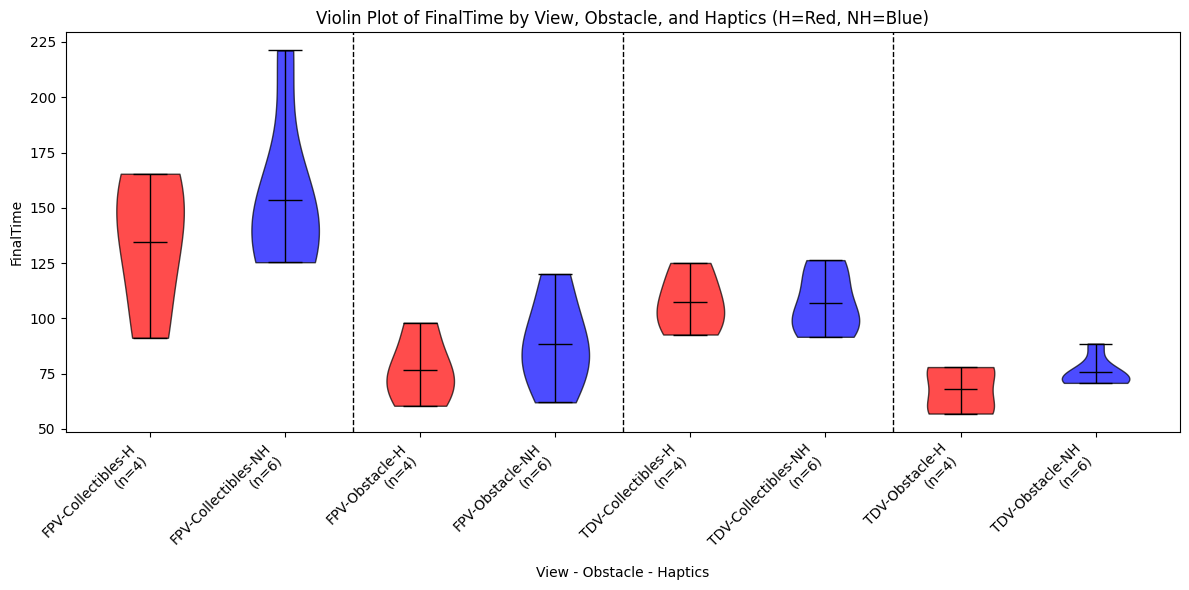

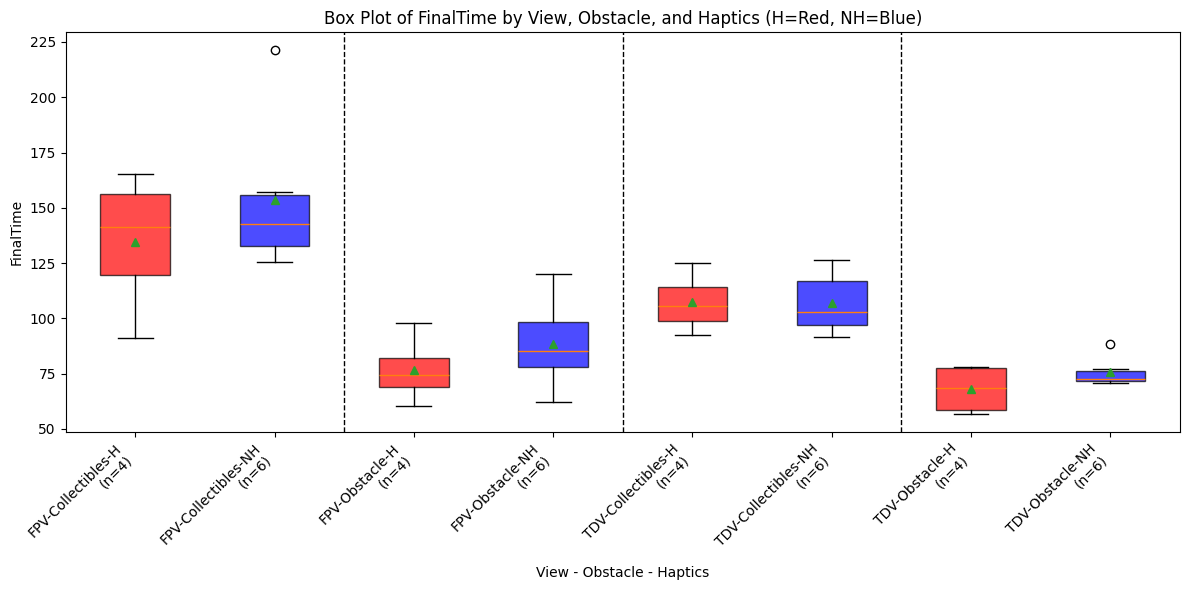

In [6]:
violinGraphSituation(dfFolders, "FinalTime")
boxPlotSituation(dfFolders, "FinalTime")

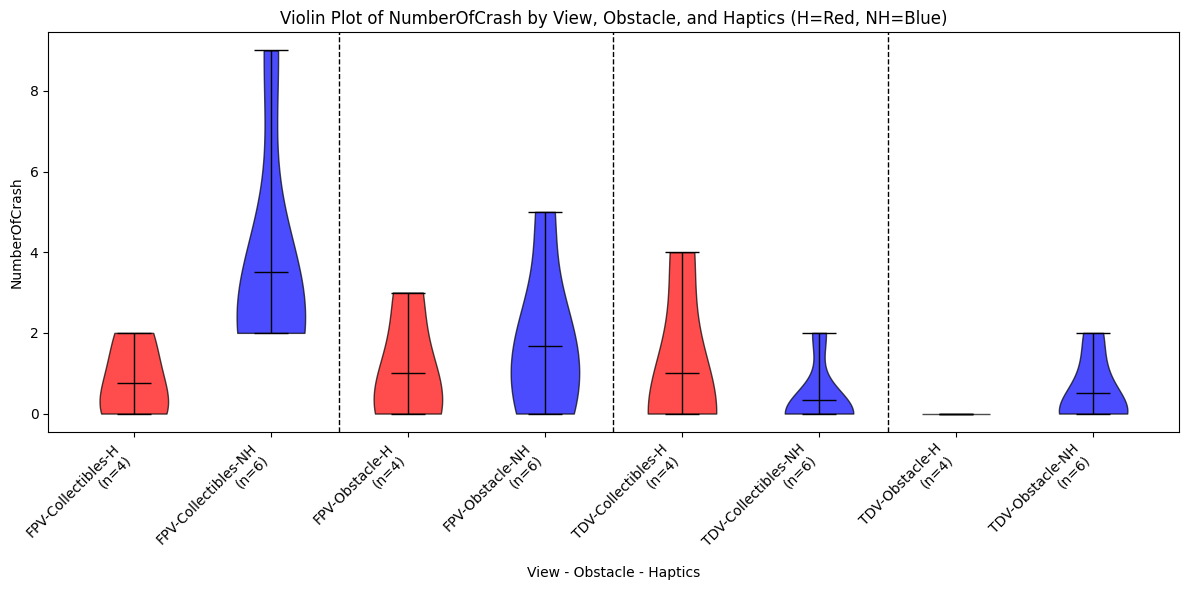

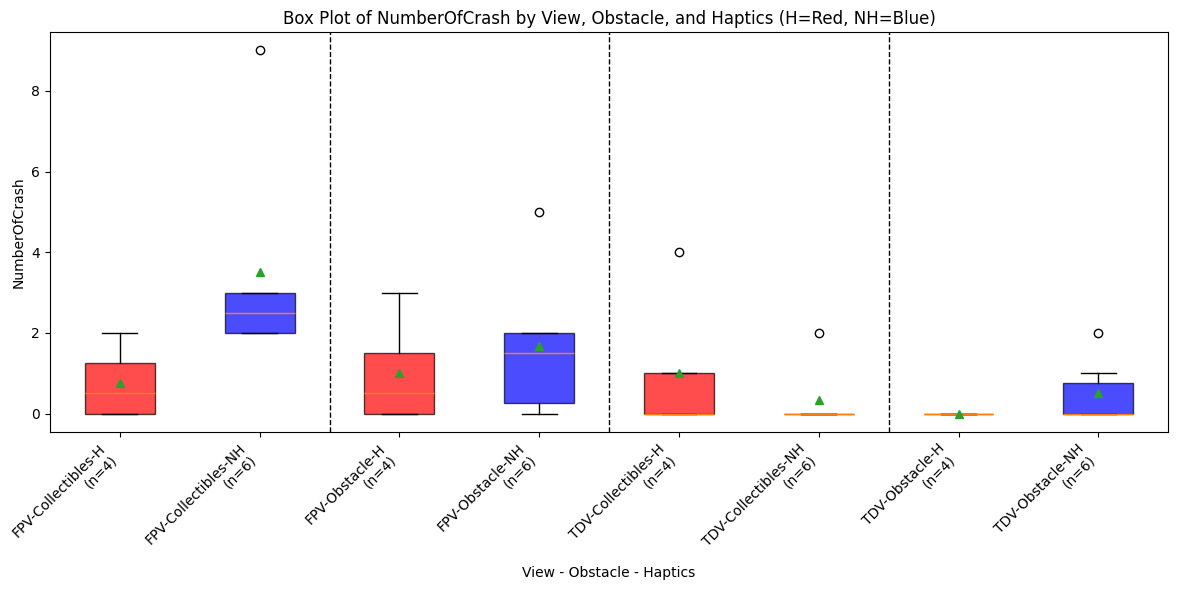

In [7]:
violinGraphSituation(dfFolders, "NumberOfCrash")
boxPlotSituation(dfFolders, "NumberOfCrash")

In [8]:
df = dfFolders.iloc[0]["SwarmState"]

fig = px.scatter_3d(
    df,
    x='posX',        # x-axis
    y='posZ',        # y-axis (floor plane)
    z='posY',        # z-axis (height)
    color='droneId', # different colors for each drone
    title="3D Trajectory Plot for All Drones",
    #scale the max and min values to make the plot look better
    range_x=[-50, 150],
    range_y=[-50, 150],
    range_z=[-50, 100]
)

# Adjust marker size or opacity as desired
fig.update_traces(marker=dict(size=3, opacity=0.8))

fig.show()

In [9]:

for index, df in dfFolders.iterrows():
    isolation_time = 1 - df["Study"]["isolation"].value_counts().loc[0] / len(df["Study"])
    dfFolders.at[index, "isolationTime"] = isolation_time

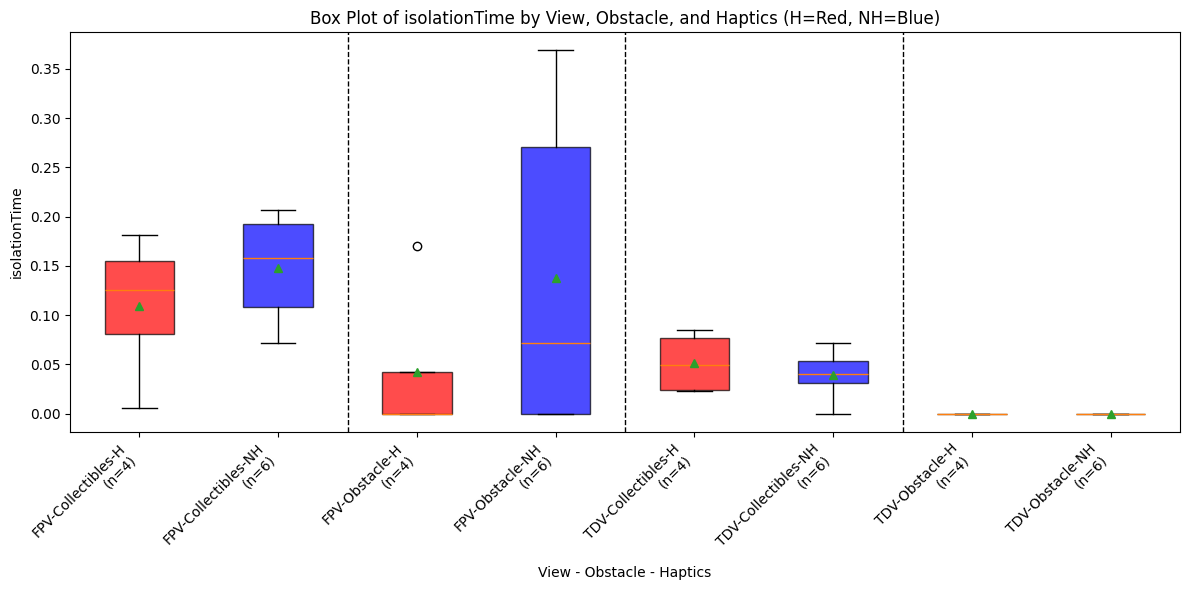

In [10]:
boxPlotSituation(dfFolders, "isolationTime")

In [15]:

for index, df in dfFolders.iterrows():
    df["Study"]["meanPosX"] = np.nan
    df["Study"]["meanPosY"] = np.nan
    df["Study"]["meanPosZ"] = np.nan
    mean_values = df["SwarmState"].groupby("Time")[["posX", "posY", "posZ"]].mean().reset_index()
    df["Study"]["meanPosX"][:-1] = mean_values["posX"].values;
    df["Study"]["meanPosY"][:-1] = mean_values["posY"].values;
    df["Study"]["meanPosZ"][:-1] = mean_values["posZ"].values;


C:\Users\Pablo\AppData\Local\Temp\ipykernel_16164\2098472268.py:6: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\Pablo\AppData\Local\Temp\ipykernel_16164\2098472268.py:6: SettingWithCopyWarning:


A value is trying to be set on a co

In [16]:
dfPlotTrajectory = pd.DataFrame(columns=["Time", "meanPosX", "meanPosY", "meanPosZ", "Obs", "View", "Haptics"])

for index, df in dfFolders.iterrows():
    dfAdded = df["Study"][["Time", "meanPosX", "meanPosY", "meanPosZ"]]
    dfAdded["Obs"] = df["Obstacle"]
    dfAdded["View"] = df["View"]
    dfAdded["Haptics"] = df["Haptics"]

    dfPlotTrajectory = pd.concat([dfPlotTrajectory, dfAdded])

    

C:\Users\Pablo\AppData\Local\Temp\ipykernel_16164\2092332662.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Pablo\AppData\Local\Temp\ipykernel_16164\2092332662.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Pablo\AppData\Local\Temp\ipykernel_16164\2092332662.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [17]:
# dfplot = dfPlotTrajectory.groupby(["View", "Obs", "Haptics", "Time"])[["meanPosX", "meanPosZ"]]
# dfHaptic = dfplot.loc["TDV", "Obstacle", "H"]
# dfNoHaptic = dfplot.loc["TDV", "Obstacle", "NH"]

# plt.figure(figsize=(12, 6))
# #map the point witht he same time and put the x and y in the same graph
# plt.plot(dfHaptic["meanPosX"], dfHaptic["meanPosZ"], 'ro', label="Haptic", markersize=.5)
# #plt.plot(dfNoHaptic["meanPosX"], dfNoHaptic["meanPosZ"], 'bo', label="No Haptic", markersize=.5)
# plt.legend()

In [18]:
def extractDf(obstacle, view, haptics):
    dfplot = dfPlotTrajectory.query(f"Obs == '{obstacle}' & View == '{view}' & Haptics == '{haptics}'")[[ "Time", "meanPosX", "meanPosY", "meanPosZ"]]
    return dfplot

In [145]:
dfplot = extractDf("Obstacle", "TDV", "H")

dfplot.dropna(inplace=True)

dfplot.sample(2)

,Time,meanPosX,meanPosY,meanPosZ
1313,36.712074,65.363355,4.885463,59.329823
2121,65.909714,31.275499,4.500300,96.282690


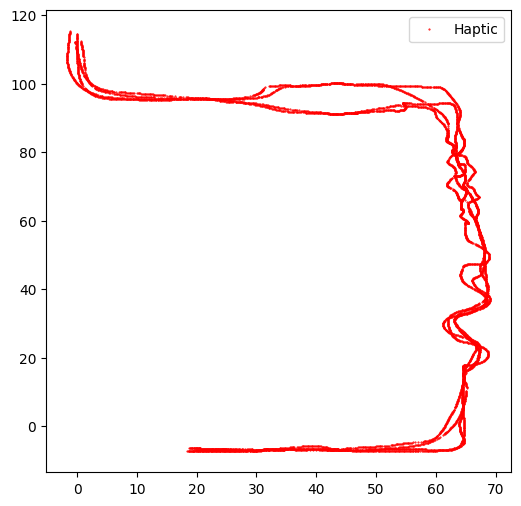

In [156]:
#scatter plot
plt.figure(figsize=(6, 6))
plt.plot(dfplot["meanPosX"], dfplot["meanPosZ"], 'ro', label="Haptic", markersize=.5)
plt.legend()

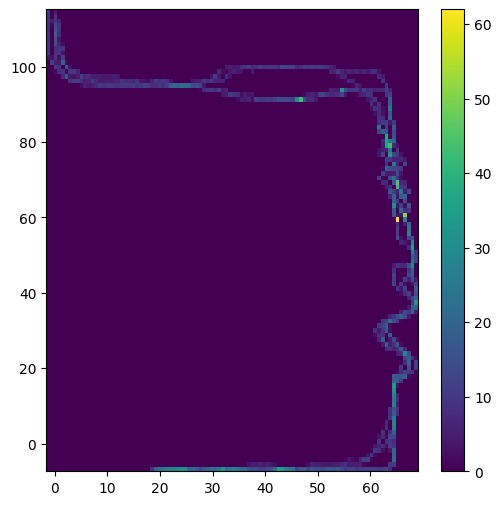

In [147]:
#make heatmap
plt.figure(figsize=(6, 6))
plt.hist2d(dfplot["meanPosX"], dfplot["meanPosZ"], bins=100)
plt.colorbar()


In [148]:
hist, xedges, yedges = np.histogram2d(dfplot["meanPosX"], dfplot["meanPosZ"], bins=100)

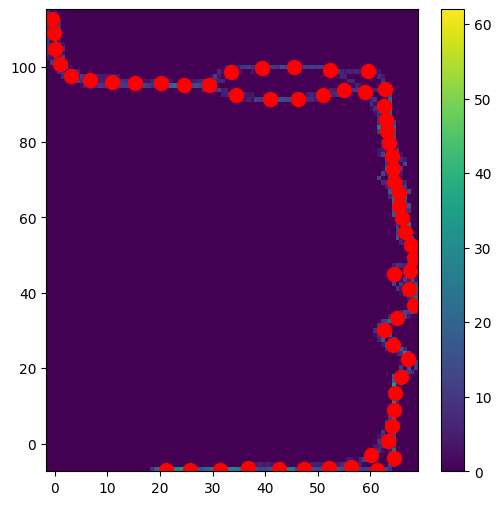

In [149]:
#apply Kmean to find the path
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=60)
kmeans.fit(dfplot[["meanPosX", "meanPosZ"]])

plt.figure(figsize=(6, 6))
plt.hist2d(dfplot["meanPosX"], dfplot["meanPosZ"], bins=100)
plt.colorbar()
#show the cluster
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red')


(array([[ 0.,  0.,  0., ...,  9.,  9., 10.],
        [ 0.,  0.,  0., ...,  5.,  0.,  0.],
        [ 0.,  0.,  0., ...,  9.,  9.,  4.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([-1.64292239, -0.93603636, -0.22915033,  0.4777357 ,  1.18462173,
         1.89150776,  2.59839379,  3.30527982,  4.01216585,  4.71905188,
         5.42593791,  6.13282394,  6.83970997,  7.546596  ,  8.25348203,
         8.96036806,  9.66725409, 10.37414012, 11.08102615, 11.78791218,
        12.49479821, 13.20168424, 13.90857027, 14.6154563 , 15.32234233,
        16.02922836, 16.73611439, 17.44300042, 18.14988645, 18.85677248,
        19.56365851, 20.27054454, 20.97743057, 21.6843166 , 22.39120263,
        23.09808866, 23.80497469, 24.51186072, 25.21874675, 25.92563278,
        26.63251881, 27.33940484, 28.04629087, 28.7531769 , 29.46006293,
        30.16694896, 30.87383499, 31.58072102, 32.28760705

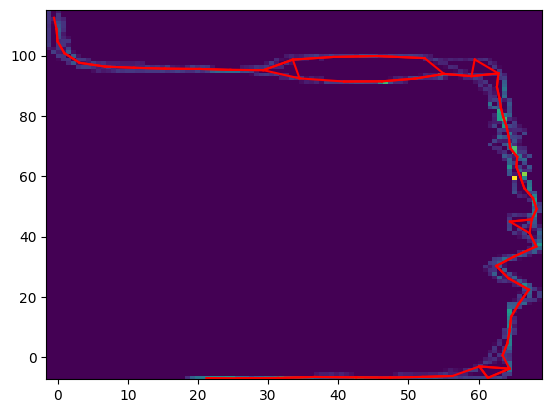

In [150]:
#each cluster can be connected to at least 2 other clusters except the first and the last one which are the cluster closest to the first adn last point
#find the closest cluster to the first and last point
from scipy.spatial import distance

startClust = dfplot.iloc[0][["meanPosX", "meanPosZ"]].values;
endClust = dfplot.iloc[-1][["meanPosX", "meanPosZ"]].values;

startClust = kmeans.cluster_centers_[distance.cdist([startClust], kmeans.cluster_centers_).argmin()];
endClust = kmeans.cluster_centers_[distance.cdist([endClust], kmeans.cluster_centers_).argmin()];

for clust in kmeans.cluster_centers_:
    if clust[0] == startClust[0] and clust[1] == startClust[1]:
        continue
    if clust[0] == endClust[0] and clust[1] == endClust[1]:
        continue

    #find the 2 closest cluster
    dist = distance.cdist([clust], kmeans.cluster_centers_);
    closest = dist.argsort()[0][1:3];

    plt.plot([clust[0], kmeans.cluster_centers_[closest[0]][0]], [clust[1], kmeans.cluster_centers_[closest[0]][1]], 'r-')
    plt.plot([clust[0], kmeans.cluster_centers_[closest[1]][0]], [clust[1], kmeans.cluster_centers_[closest[1]][1]], 'r-')
    

plt.plot([startClust[0], kmeans.cluster_centers_[distance.cdist([startClust], kmeans.cluster_centers_).argmin()][0]], [startClust[1], kmeans.cluster_centers_[distance.cdist([startClust], kmeans.cluster_centers_).argmin()][1]], 'r-')
plt.hist2d(dfplot["meanPosX"], dfplot["meanPosZ"], bins=100)




In [151]:
import networkx as nx

def compute_network_path(kmeans, startClust, endClust):
    """
    Build the network graph from kmeans.cluster_centers_ where:
      - Every cluster (except the start and end) is connected to its two closest clusters.
      - The start and end clusters are each connected to their nearest neighbor.
    
    Then, compute the shortest path (by Euclidean distance) from the start cluster to the end cluster.
    
    Parameters:
        kmeans   : The fitted k-means object with attribute cluster_centers_ (numpy array of shape (n_clusters, 2)).
        startClust : Numpy array [x, y] representing the start cluster.
        endClust   : Numpy array [x, y] representing the end cluster.
        
    Returns:
        path_coords : A list of cluster centers (each as [x, y]) representing the ordered path from start to end.
    """
    centers = kmeans.cluster_centers_
    G = nx.Graph()
    
    # Add each cluster center as a node in the graph.
    for i, c in enumerate(centers):
        G.add_node(i, pos=c)
    
    # Identify indices of the start and end clusters.
    start_index = np.where((centers == startClust).all(axis=1))[0][0]
    end_index   = np.where((centers == endClust).all(axis=1))[0][0]
    
    # For each cluster (except start and end), connect to its two closest clusters.
    for i, c in enumerate(centers):
        if i == start_index or i == end_index:
            continue  # Skip the start and end clusters.
        dists = distance.cdist([c], centers)[0]
        sorted_indices = np.argsort(dists)
        # The closest is itself (distance 0), so take the next two.
        for j in sorted_indices[1:3]:
            G.add_edge(i, j, weight=dists[j])
    
    # For the start cluster, add an edge to its nearest neighbor (ignoring itself).
    dists = distance.cdist([startClust], centers)[0]
    sorted_indices = np.argsort(dists)
    neighbor = sorted_indices[1]
    G.add_edge(start_index, neighbor, weight=dists[neighbor])
    
    # For the end cluster, add an edge to its nearest neighbor.
    dists = distance.cdist([endClust], centers)[0]
    sorted_indices = np.argsort(dists)
    neighbor = sorted_indices[1]
    G.add_edge(end_index, neighbor, weight=dists[neighbor])
    
    # Compute the shortest path from the start to end cluster.
    path_indices = nx.shortest_path(G, source=start_index, target=end_index, weight='weight')
    
    # Convert node indices back to coordinates.
    path_coords = [centers[i] for i in path_indices]
    return path_coords

def get_progress(x, y, path):
    """
    Compute a progress index (0 = start, 1 = end) for a given point (x, y) along a path.
    
    The path is assumed to be an ordered list of points (each as [x, y]). The function works by
    projecting the point onto each segment of the path and selecting the projection with the minimum distance.
    Then it calculates the cumulative distance from the start of the path to that projection and normalizes by
    the total path length.
    
    Parameters:
        x, y : Coordinates of the query point.
        path : Ordered list of points (each as [x, y]) defining the path from start to end.
    
    Returns:
        progress : A float between 0 (at the start) and 1 (at the end) indicating the point's relative position along the path.
    """
    P = np.array([x, y])
    
    # Compute cumulative distances along the path.
    cumulative = [0]
    total_length = 0
    for i in range(1, len(path)):
        seg_length = np.linalg.norm(np.array(path[i]) - np.array(path[i-1]))
        total_length += seg_length
        cumulative.append(total_length)
    
    # Project P onto each segment and find the closest projection.
    min_dist = float('inf')
    proj_length = None  # Distance along the path corresponding to the best projection.
    for i in range(1, len(path)):
        A = np.array(path[i-1])
        B = np.array(path[i])
        AB = B - A
        seg_len_sq = np.dot(AB, AB)
        if seg_len_sq == 0:  # Degenerate segment.
            continue
        t = np.dot(P - A, AB) / seg_len_sq
        t_clamped = np.clip(t, 0, 1)
        proj = A + t_clamped * AB  # Projection of P onto segment [A, B]
        d = np.linalg.norm(P - proj)
        if d < min_dist:
            min_dist = d
            seg_length = np.linalg.norm(AB)
            proj_length = cumulative[i-1] + t_clamped * seg_length

    progress = proj_length / total_length
    return progress

(array([[ 0.,  0.,  0., ...,  9.,  9., 10.],
        [ 0.,  0.,  0., ...,  5.,  0.,  0.],
        [ 0.,  0.,  0., ...,  9.,  9.,  4.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([-1.64292239, -0.93603636, -0.22915033,  0.4777357 ,  1.18462173,
         1.89150776,  2.59839379,  3.30527982,  4.01216585,  4.71905188,
         5.42593791,  6.13282394,  6.83970997,  7.546596  ,  8.25348203,
         8.96036806,  9.66725409, 10.37414012, 11.08102615, 11.78791218,
        12.49479821, 13.20168424, 13.90857027, 14.6154563 , 15.32234233,
        16.02922836, 16.73611439, 17.44300042, 18.14988645, 18.85677248,
        19.56365851, 20.27054454, 20.97743057, 21.6843166 , 22.39120263,
        23.09808866, 23.80497469, 24.51186072, 25.21874675, 25.92563278,
        26.63251881, 27.33940484, 28.04629087, 28.7531769 , 29.46006293,
        30.16694896, 30.87383499, 31.58072102, 32.28760705

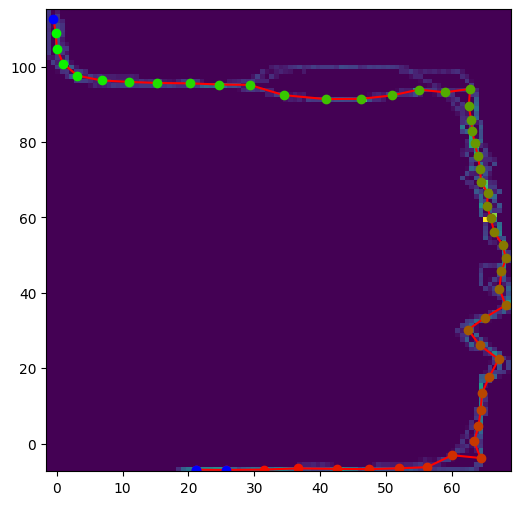

In [198]:
#plot the path with colored clusters
dfplot.dropna(inplace=True)
path = compute_network_path(kmeans, startClust, endClust)

plt.figure(figsize=(6, 6))
#PLOT color gradient for the path starting from red to green
for i in range(len(path) - 1):
    plt.plot([path[i][0], path[i+1][0]], [path[i][1], path[i+1][1]], 'r-')
    progress = get_progress(path[i][0], path[i][1], path)
    color = (1 - progress, progress, 0)
    plt.plot(path[i][0], path[i][1], 'o', color=color)

plt.plot([startClust[0], endClust[0]], [startClust[1], endClust[1]], 'bo')
plt.plot([startClust[0], path[1][0]], [startClust[1], path[1][1]], 'bo')

plt.hist2d(dfplot["meanPosX"], dfplot["meanPosZ"], bins=100)




In [153]:
dfplot["progress"] = dfplot.apply(lambda row: get_progress(row["meanPosX"], row["meanPosZ"], path), axis=1)

In [154]:
dfplot.sample(2)

,Time,meanPosX,meanPosY,meanPosZ,progress
1145,30.910896,66.625922,4.945717,47.303712,0.443801
2033,62.476429,43.414570,4.497143,100.169974,0.745083


C:\Users\Pablo\AppData\Local\Temp\ipykernel_16164\1106824323.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Pablo\AppData\Local\Temp\ipykernel_16164\1106824323.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



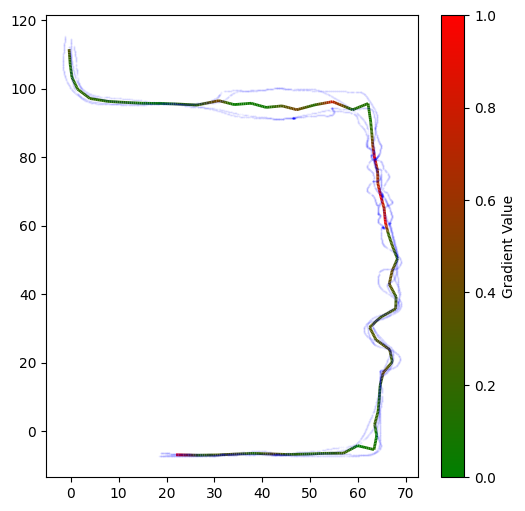

In [202]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection

#make bin bar of the progress and compute the average position

dfplot["progressBin"] = pd.cut(dfplot["progress"], bins=60)
dfplot["meanPosXReal"] = dfplot["meanPosX"].astype(float)
dfplot["meanPosYReal"] = dfplot["meanPosZ"].astype(float)

dfplotFinal = dfplot.groupby("progressBin")[["meanPosXReal", "meanPosYReal"]].mean().reset_index()

color = dfplot.groupby("progressBin")[["meanPosXReal"]].count().reset_index()
color["meanPosXReal"] = (color["meanPosXReal"] - color["meanPosXReal"].min()) / (color["meanPosXReal"].nlargest(2).iloc[-1] - color["meanPosXReal"].min())
color["meanPosXReal"] = color["meanPosXReal"].clip(0, 1)

#make the color from green to red
color["color"] = color["meanPosXReal"]

dfplotFinal = dfplotFinal.merge(color[["progressBin", "color"]], on="progressBin")



# Get the values from your DataFrame
x = dfplotFinal["meanPosXReal"].values
y = dfplotFinal["meanPosYReal"].values
c = dfplotFinal["color"].values  # these should be values between 0 and 1

# Create line segments from the x,y points.
# Each segment is defined by two consecutive points.
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Compute an average color for each segment
seg_colors = (c[:-1] + c[1:]) / 2

# Create a LineCollection. The cmap 'viridis' will be used,
# and the norm ensures the colormap spans from 0 to 1.
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['green', 'red'])

# Number of interpolation steps per segment (higher = smoother gradient)
num_interp = 10  

# Create interpolated segments and colors
new_segments = []
new_colors = []

for i in range(len(x) - 1):
    # Linearly interpolate points along the segment
    interp_x = np.linspace(x[i], x[i+1], num_interp)
    interp_y = np.linspace(y[i], y[i+1], num_interp)
    
    # Linearly interpolate colors for smooth transition
    interp_c = np.linspace(c[i], c[i+1], num_interp)

    # Create the sub-segments
    for j in range(num_interp - 1):
        new_segments.append([[interp_x[j], interp_y[j]], [interp_x[j+1], interp_y[j+1]]])
        new_colors.append(interp_c[j])  # Assign color gradually along the segment

# Convert to NumPy array for `LineCollection`
new_segments = np.array(new_segments)

# Create the LineCollection with the interpolated color map
lc = LineCollection(new_segments, cmap=custom_cmap, norm=plt.Normalize(0, 1))
lc.set_array(np.array(new_colors))
lc.set_linewidth(2)

# Plotting the gradient line
fig, ax = plt.subplots(figsize=(6, 6))
ax.add_collection(lc)
plt.colorbar(lc, ax=ax, label="Gradient Value")

# Also plot the Haptic points
ax.plot(dfplot["meanPosX"], dfplot["meanPosZ"], 'o', markersize=0.5, alpha=0.05, color='blue')

plt.show()

In [187]:
dfplotFinal.describe()

,meanPosXReal,meanPosYReal,color
count,100.000000,100.000000,100.000000
mean,47.486638,52.596406,0.659771
std,21.823652,42.288673,0.196441
min,-0.475085,-7.080885,0.000000
25%,33.112130,8.163279,0.614504
50%,59.434381,59.252967,0.709924
75%,64.547238,95.432996,0.767176
max,68.367388,112.303228,1.000000
